In [ ]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class FLD:
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = []
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None

        self.classes = None
        self.n_samples = None
        self.n_features = None
        self.classes_samples = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.n_samples, self.n_features = X.shape
        self.classes_samples = np.zeros([self.classes.shape[0],1])
        C1 = []
        C2 = []
        C3 = []
        for i in range(self.n_samples):
            # class1
            if y[i] == self.classes[0]:
                C1.append(X[i])
                self.classes_samples[0] += 1
            # class2    
            elif y[i] == self.classes[1]:
                C2.append(X[i])
                self.classes_samples[1] += 1
            # class3
            elif y[i] == self.classes[2]:
                C3.append(X[i])
                self.classes_samples[2] += 1
        
        C1 = np.array(C1)
        C2 = np.array(C2)
        C3 = np.array(C3)
        
        self.mean_vectors.extend([C1.mean(axis=0),C2.mean(axis=0),C3.mean(axis=0)])
        # compute sw
        sk1 = np.zeros([self.n_features, self.n_features])
        sk2 = np.zeros([self.n_features, self.n_features])
        sk3 = np.zeros([self.n_features, self.n_features])
        
        for x in C1:
            mat = x-self.mean_vectors[0]
            mat = mat.reshape((mat.shape[0], 1))
            sk1 += np.dot(mat, mat.T)
        
        for x in C2:
            mat = x-self.mean_vectors[1]
            mat = mat.reshape((mat.shape[0], 1))
            sk2 += np.dot(mat, mat.T)
        
        for x in C3:
            mat = x-self.mean_vectors[2]
            mat = mat.reshape((mat.shape[0], 1))
            sk3 += np.dot(mat, mat.T)
        
        self.sw = sk1 + sk2 + sk3

        # compute sb
        overall_m = X.mean(axis=0)
        self.sb = np.zeros([self.n_features, self.n_features])
        for i in range(self.classes.shape[0]):
            # print(i)
            mat = self.mean_vectors[i] - overall_m
            mat = mat.reshape((mat.shape[0], 1))
            self.sb += self.classes_samples[i] * (np.dot(mat, mat.T))

        # compute w
        # find eigenvalue, eigenvector pairs 
        mat = np.dot(np.linalg.pinv(self.sw), self.sb)
        eigvals, eigvecs = np.linalg.eig(mat)
        eiglist = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]

        # sort the eigvals in decreasing order
        eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)
        
        # take the first eigvectors
        self.w = np.array([eiglist[0][1]])     # project to dim 1
        self.w = self.w.reshape((self.n_features, 1))
        # print(self.w)
        pass

    def distance(self, pa, pb):
        return np.sum((pa-pb)**2)**0.5

    def predict_using_class_mean(self, X, y, X_test):
        
        proj_mean = np.zeros([self.classes.shape[0], 2])
        for i in range(self.classes.shape[0]):
            proj_mean[i] = np.dot(self.w.T, self.mean_vectors[i])
        #print(proj_mean)
        proj_X_test = np.zeros([X_test.shape[0], 2])
        for i in range(X_test.shape[0]):
            proj_X_test[i] = np.dot(self.w.T, X_test[i])
        
        y_pred=[]
        distances = np.zeros([proj_X_test.shape[0], self.classes.shape[0]])
        # distances = -2 * np.dot(proj_mean, proj_X_test.T) + np.sum(proj_X_test**2,axis=1) + np.sum(proj_mean**2,axis=1)[:, np.newaxis]
        for i in range(proj_X_test.shape[0]):
            for j in range(self.classes.shape[0]):
                distances[i][j] = self.distance(proj_X_test[i], proj_mean[j])
        
        y_pred = np.argmin(distances, axis=1)
        return y_pred

    def knn(self, X, X_test, k=1):
       
        # calculates the Euclidean distances.
        distances = -2 * np.dot(X, X_test.T) + np.sum(X_test**2,axis=1) + np.sum(X**2,axis=1)[:, np.newaxis]
        distances[distances < 0] = 0
        distances = distances**.5
        indices = np.argsort(distances, 0)    # get indices of sorted items
        distances = np.sort(distances,0)      # distances sorted in axis 0
        # returning the top-k closest distances.
        return indices[0:k, : ], distances[0:k, : ]

    def predict_using_knn(self, X, y, X_test, k=1):
        proj_X = np.zeros([self.n_samples, 2])
        proj_X_test = np.zeros([X_test.shape[0], 2])
        
        for i in range(self.n_samples):
            proj_X[i] = np.dot(self.w.T, X[i])
        
        for i in range(X_test.shape[0]):
            proj_X_test[i] = np.dot(self.w.T, X_test[i])

        # predicte by nearest-neighbor
        indices, distances = self.knn(proj_X, proj_X_test, k)
        y = y.flatten()
        rows, columns = indices.shape
        y_pred = []
        for j in range(columns):
            temp = []
            for i in range(rows):
                cell = indices[i][j]
                temp.append(y[cell])
            y_pred.append(max(temp,key=temp.count)) #this is the key function, brings the mode value
        y_pred = np.array(y_pred)
        
        return y_pred

    def show_confusion_matrix(self, y, y_pred):
        
        confusion_matrix = pd.crosstab(y, y_pred).to_numpy()
        plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)
        plt.ylim(len(self.classes) - 0.5, -0.5)
        fmt = 'd'
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                plt.text(j, i, format(confusion_matrix[i, j], fmt),
                  horizontalalignment="center" )
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
   
        pass

    def plot_projection(self, X, y):
        class1_x = []
        class1_y = []
        class2_x = []
        class2_y = []
        class3_x = []
        class3_y = []
        proj1_x = []
        proj1_y = []
        proj2_x = []
        proj2_y = []
        proj3_x = []
        proj3_y = []
        slope = float(self.w[1] / self.w[0])  # slope = y/x
        intercept = 6

        # Projection line
        x_line = np.linspace(-8, 3, 1000)
        y_line = []
        for i in x_line:
            y_line += [slope * i + intercept]

        # Classification ans project point
        for i in range(X.shape[0]):
            proj = self.w[0] * (X[i][0] - x_line[0]) + self.w[1] * (X[i][1] - y_line[0])
            proj /= (self.w[0]**2 + self.w[1]**2)
            proj = proj * self.w
            # class1
            if y[i] == self.classes[0]:
                class1_x.append(X[i][0])
                class1_y.append(X[i][1])
                # project data
                proj1_x.append(proj[0] + x_line[0])
                proj1_y.append(proj[1] + y_line[0])
            # class2    
            elif y[i] == self.classes[1]:
                class2_x.append(X[i][0])
                class2_y.append(X[i][1])
                # project data
                proj2_x.append(proj[0] + x_line[0])
                proj2_y.append(proj[1] + y_line[0])
            elif y[i] == self.classes[2]:
                class3_x.append(X[i][0])
                class3_y.append(X[i][1])
                # project data
                proj3_x.append(proj[0] + x_line[0])
                proj3_y.append(proj[1] + y_line[0])

        #plt.figure(figsize=(6, 6))
        plt.title(f"Projection line: w={slope}, b={intercept}")
        plt.plot(x_line, y_line)
        plt.scatter(class1_x, class1_y, s=3, color='red')
        plt.scatter(class2_x, class2_y, s=3, color='blue')
        plt.scatter(class3_x, class3_y, s=3, color='green')
        plt.scatter(proj1_x, proj1_y, s=3, color='red')
        plt.scatter(proj2_x, proj2_y, s=3, color='blue')
        plt.scatter(proj3_x, proj3_y, s=3, color='green')
        plt.plot([class1_x, proj1_x], [class1_y, proj1_y], color='red', lw=0.1)     #lightsteelblue
        plt.plot([class2_x, proj2_x], [class2_y, proj2_y], color='blue', lw=0.1)
        plt.plot([class3_x, proj3_x], [class3_y, proj3_y], color='green', lw=0.1)
        plt.show()
        pass

    def accuracy_score(self, y, y_pred):
        sum = np.sum(y_pred == y)
        return sum/self.n_samples

In [ ]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.epoch = []
        self.train_loss = []
        self.weights = None
        self.n_samples = None
        self.n_features = None
        self.classes = None

    def fit(self, X, y, batch_size=16, lr=0.001, epoch=100):
        y_onehot = pd.get_dummies(y).to_numpy()
        self.n_samples, self.n_features = X.shape
        self.weights = np.zeros((X.shape[1], y_onehot.shape[1]))
        self.classes = np.unique(y).reshape(3,1)
        
        for i in range(epoch):
            self.weights -= lr* self.gradient(X, y_onehot)
            Z = -np.dot(X, self.weights) 
            y_probs = self.softmax(Z)
            y_probs = np.max(y_probs, axis=1)
      
            self.train_loss.append(self.cross_entropy(y, y_probs))
            self.epoch.append(i)
        pass

    
    def gradient(self, X, y):
        """
        y: onehot encoded 
        """
        Z = -np.dot(X, self.weights)
        y_pred = self.softmax(Z)  
        gradient = 1/self.n_samples * (np.dot(X.T, (y - y_pred)))+ 2 * 0.01 * self.weights #L2 norm
        return gradient

    def predict(self, X):
        Z = -np.dot(X, self.weights)
        y_probs = self.softmax(Z)  
        return np.argmax(y_probs, axis=1)
        

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return self.accuracy_score(y, y_pred)
        
    def softmax(self, z):
        a = np.exp(z)/np.sum(np.exp(z),axis=1).reshape(-1,1)
        return a

    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))
    
    def accuracy_score(self, y, y_pred):
        sum = np.sum(y_pred == y)
        return sum/self.n_samples

    def plot_curve(self):
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("CE loss")
        plt.plot(self.epoch, self.train_loss, label="Train CE loss")
        plt.legend(loc="upper right")
        plt.show() 
    
    def show_confusion_matrix(self, X, y):
        y_pred = self.predict(X)
        confusion_matrix = pd.crosstab(y, y_pred).to_numpy()
        plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)
        plt.ylim(len(self.classes) - 0.5, -0.5)
        fmt = 'd'
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                plt.text(j, i, format(confusion_matrix[i, j], fmt),
                  horizontalalignment="center" )
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

# Prepare data for Q1 ~ Q12

In [ ]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [ ]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000,)
X_test (1000, 2)
y_test (1000,)


# MultiClass Logistic Regression

In [ ]:
# For Q1
lr = 0.05
batch_size = 16
epoch = 100

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)

In [ ]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.897


In [ ]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.885


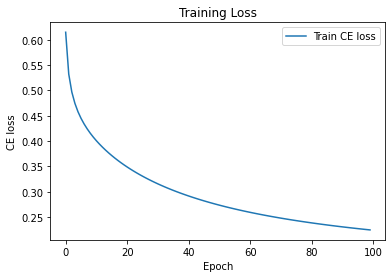

In [ ]:
# For Q4
logistic_reg.plot_curve()

/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


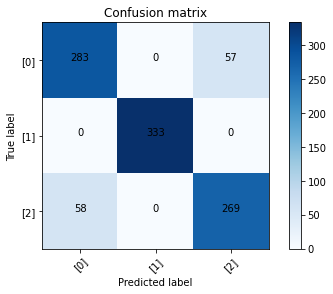

In [ ]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

# Fisher's Linear Discriminant Analysis

In [ ]:
fld = FLD()

fld.fit(X_train, y_train)

In [ ]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [array([-4.17505764,  6.35526804]), array([-9.43385176, -4.87830741]), array([-2.54454008,  7.53144179])]


In [ ]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [ ]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [ ]:
# For Q9
print("W: ", fld.w)

W:  [[-0.44115384]
 [-0.8974315 ]]


FLD using class mean, accuracy:  0.861


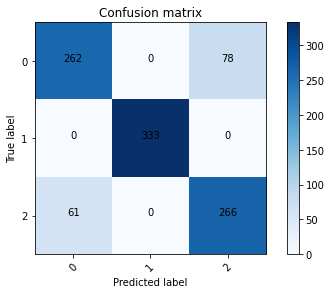

In [ ]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

In [ ]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.822
FLD using knn (k=2), accuracy:  0.822
FLD using knn (k=3), accuracy:  0.843
FLD using knn (k=4), accuracy:  0.838
FLD using knn (k=5), accuracy:  0.862


/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


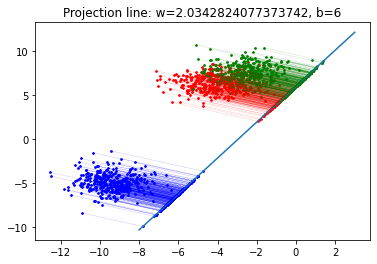

In [ ]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [ ]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [ ]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [ ]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


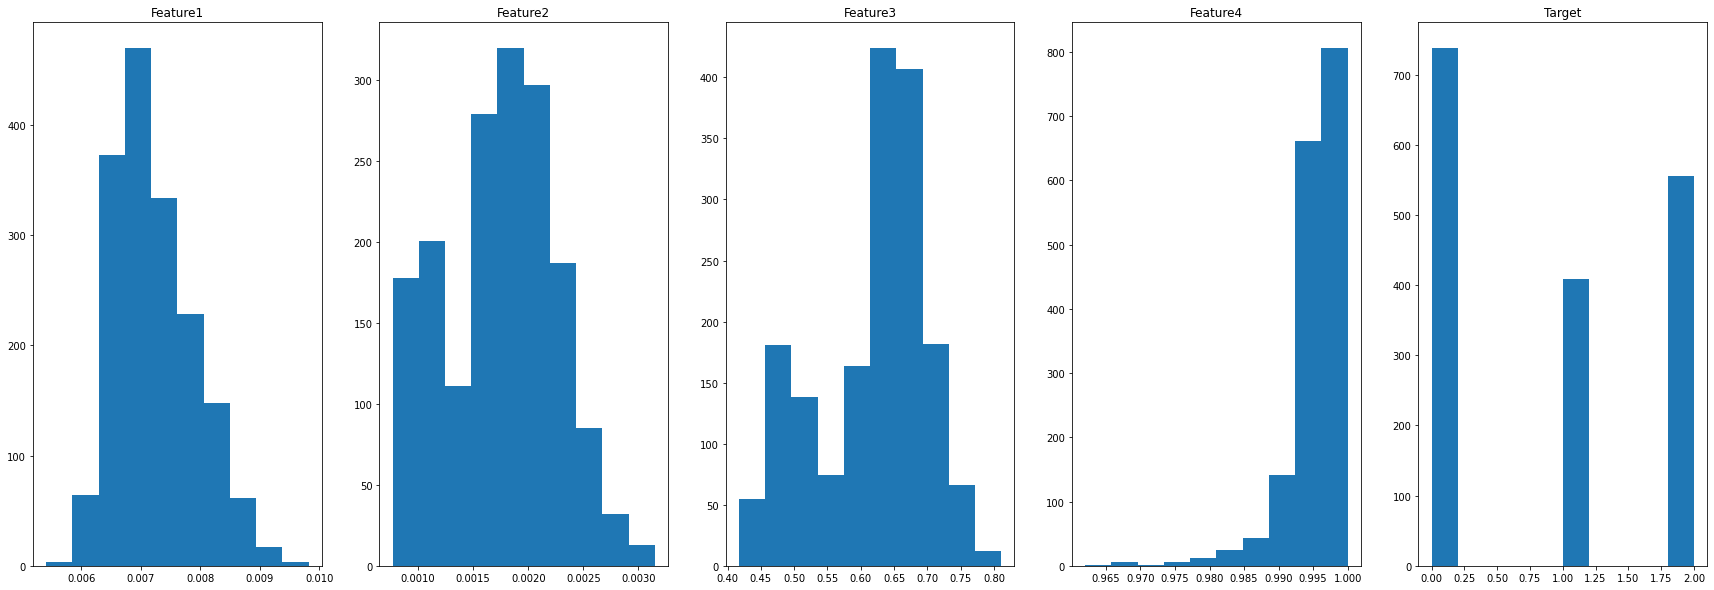

In [ ]:
# Data processing

# Refer to section "Prepare data for Q1 ~ Q12"
fig, axes = plt.subplots(1, 5, figsize=(30, 10))
axes[0].hist(df_train['Feature1'])
axes[0].set_title("Feature1")
axes[1].hist(df_train['Feature2'])
axes[1].set_title("Feature2")
axes[2].hist(df_train['Feature3'])
axes[2].set_title("Feature3")
axes[3].hist(df_train['Feature4'])
axes[3].set_title("Feature4")
axes[4].hist(df_train['Target'])
axes[4].set_title("Target")
plt.show()

### Oversampling

In [ ]:
def oversampling(X):
    classes = np.unique(X['Target']).astype(int)
    count = (X['Target'].value_counts()).sort_index()
    max_num = max(count)
    sample = abs(count - max_num)
    X_oversample = X

    for c in classes:
        if sample[c] == 0: continue
        if sample[c] > count[c]:
          part1 = sample[c] - count[c]
          part2 = count[c]
          random1 = np.random.randint(0, count[c]-1, size=part1)
          random2 = np.random.randint(0, count[c]-1, size=part2)
          X_hat = X[X['Target'] == c].reset_index(drop=True) 
          new_data = X_hat.iloc[random1].append(X_hat.iloc[random2])   
        else:
          random = np.random.randint(0, sample[c], size=sample[c])
          X_hat = X[X['Target'] == c].reset_index(drop=True)  
          new_data = X_hat.iloc[random]  
          
        X_oversample = X_oversample.append(new_data, ignore_index=True)
        
    return X_oversample

In [ ]:
def SMOTE(X, y, k, num_synthetic):
    n_classes = len(np.unique(y))
    n_samples, n_features = X.shape
    synthetic_X = np.zeros((n_classes * num_synthetic, n_features))
    synthetic_y = np.zeros(n_classes * num_synthetic, dtype=int)
    
    # For each class
    for c in np.unique(y):
        # Get all samples of the current class
        c = int(c)
        X_c = X[y == c]
        n_c = X_c.shape[0]
        # Get the k nearest neighbors for each sample in the current class
        dists = np.sqrt(np.sum((X_c[:, np.newaxis, :] - X_c) ** 2, axis=2))
        knn_indices = np.argsort(dists, axis=1)[:, 1:k+1]
        # Generate synthetic samples
        for i in range(num_synthetic):
            j = np.random.randint(0, n_c)
            # Choose a random nearest neighbor of the current sample
            nn = np.random.choice(knn_indices[j])
            # Generate synthetic sample
            diff = X_c[nn] - X_c[j]
            factor = np.random.rand()
            synthetic_X[c*num_synthetic + i] = X_c[j] + factor * diff
            synthetic_y[c*num_synthetic + i] = c
    # Combine the original and synthetic samples
    X_resampled = np.vstack((X, synthetic_X))
    y_resampled = np.concatenate((y, synthetic_y))
    return X_resampled, y_resampled


In [ ]:
# oversample
os_df_train = oversampling(df_train)
os_df_val = oversampling(df_val)
# df_test = oversampling(df_test)
X_train = os_df_train.to_numpy()
y_train = os_df_train['Target'].to_numpy().ravel()

X_val = os_df_val.to_numpy()
y_val = os_df_val['Target'].to_numpy().ravel()

fld = FLD()
fld.fit(X_train, y_train)

y_pred = fld.predict_using_class_mean(X_train, y_train, X_val)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_val, y_pred))

FLD using class mean, accuracy:  0.37037037037037035


<ipython-input-23-74f6f989fa8a>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_oversample = X_oversample.append(new_data, ignore_index=True)
<ipython-input-23-74f6f989fa8a>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = X_hat.iloc[random1].append(X_hat.iloc[random2])
<ipython-input-23-74f6f989fa8a>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_oversample = X_oversample.append(new_data, ignore_index=True)


In [ ]:
# SMOTE
X_train = df_train.to_numpy()
y_train = df_train['Target'].to_numpy().ravel()

X_val = df_val.to_numpy()
y_val = df_val['Target'].to_numpy().ravel()

X_resampled, y_resampled = SMOTE(X_train, y_train, k=20, num_synthetic=5000)
X_resampled_val, y_resampled_val = SMOTE(X_val, y_val, k=20,num_synthetic=5000)

fld = FLD()
fld.fit(X_resampled, y_resampled)

y_pred = fld.predict_using_class_mean(X_resampled, y_resampled, X_resampled_val)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_resampled_val, y_pred))

FLD using class mean, accuracy:  0.8111117763276058


Pearson Correlation

In [ ]:
features = np.array(df_train.columns)
df = pd.DataFrame(df_train.corr(),index = features, columns=features)
df.style.background_gradient(cmap ='Blues')

,Feature1,Feature2,Feature3,Feature4,Target
Feature1,1.000000,0.532584,0.224169,0.214851,-0.657016
Feature2,0.532584,1.000000,0.938422,0.431155,-0.477465
Feature3,0.224169,0.938422,1.000000,0.421574,-0.265032
Feature4,0.214851,0.431155,0.421574,1.000000,-0.215316
Target,-0.657016,-0.477465,-0.265032,-0.215316,1.000000


Select feature by Pearson Correlation

In [ ]:
X_train = df_train
y_train = df_train['Target'].to_numpy().ravel()

X_val = df_val
y_val = df_val['Target'].to_numpy().ravel()

lr = 0.05
epochs = 100
batch_size = 16

thresholds = [0.2, 0.25, 0.4, 0.6]

for threshold in thresholds:
    highly_corr_features = X_train.columns[X_train.corr()['Target'].abs() > threshold]
    highly_corr_features = highly_corr_features.drop('Target')
    
    x_train_subset = X_train[highly_corr_features]
    x_val_subset = X_val[highly_corr_features]
    print('\n', highly_corr_features)
    # convert data to NumPy  
    x_train_subset = x_train_subset.to_numpy()
    x_val_subset = x_val_subset.to_numpy()
    
    fld = FLD()
    fld.fit(x_train_subset, y_train)

    y_pred = fld.predict_using_class_mean(x_train_subset, y_train, x_val_subset)
    print("FLD using class mean, accuracy: ", fld.accuracy_score(y_val, y_pred))


 Index(['Feature1', 'Feature2', 'Feature3', 'Feature4'], dtype='object')
FLD using class mean, accuracy:  0.35290663534938344

 Index(['Feature1', 'Feature2', 'Feature3'], dtype='object')
FLD using class mean, accuracy:  0.35231943628890194

 Index(['Feature1', 'Feature2'], dtype='object')
FLD using class mean, accuracy:  0.367586611861421

 Index(['Feature1'], dtype='object')
FLD using class mean, accuracy:  0.26189078097475044


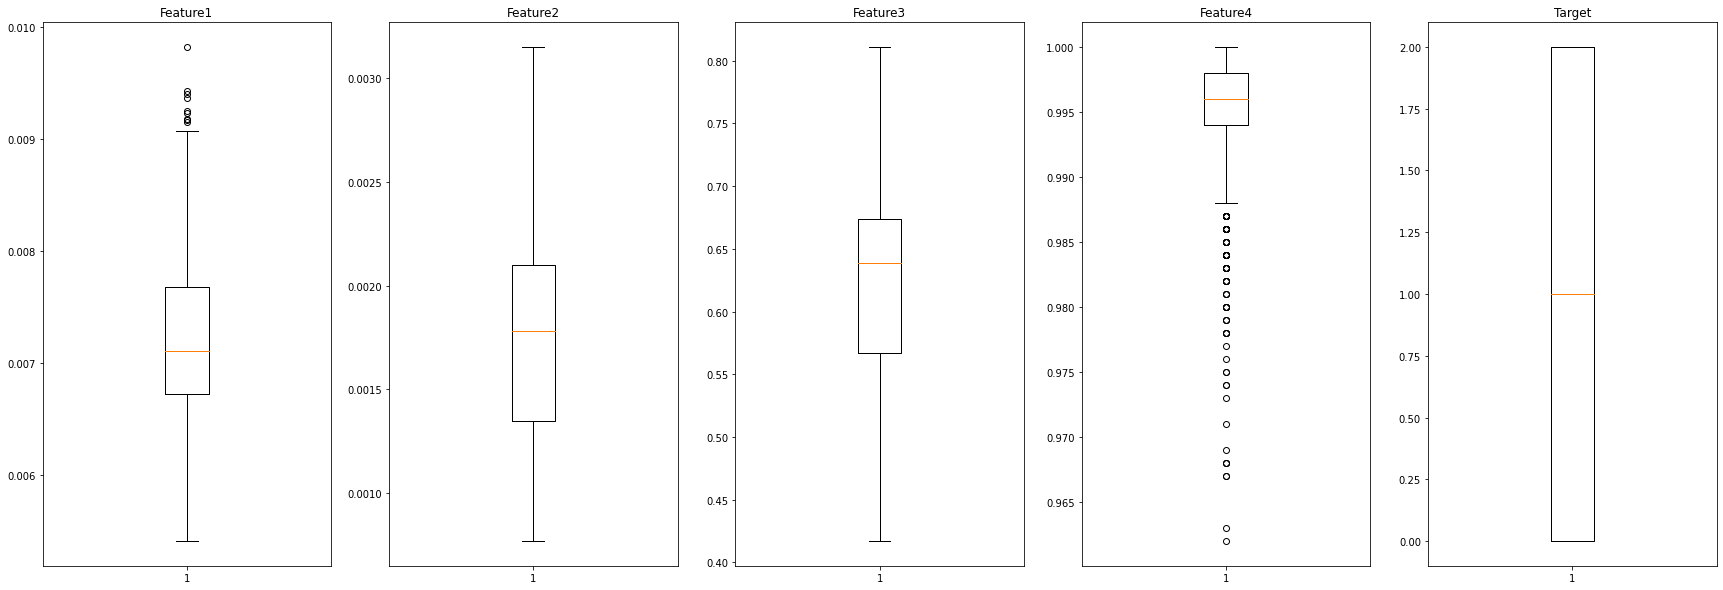

In [ ]:
fig, axes = plt.subplots(1,5, figsize =(30, 10))
# Creating plot
axes[0].boxplot(df_train['Feature1'])
axes[0].set_title("Feature1")
axes[1].boxplot(df_train['Feature2'])
axes[1].set_title("Feature2")
axes[2].boxplot(df_train['Feature3'])
axes[2].set_title("Feature3")
axes[3].boxplot(df_train['Feature4'])
axes[3].set_title("Feature4")
axes[4].boxplot(df_train['Target'])
axes[4].set_title("Target")
plt.show()

In [ ]:
def outlier(data):
  q1 = np.quantile(data, 0.25)
  q3 = np.quantile(data, 0.75)
  med = np.median(data)
  
  iqr = q3-q1
  upper_bound = q3+(1.5*iqr)
  lower_bound = q1-(1.5*iqr)

  outliers = data[(data <= lower_bound) | (data >= upper_bound)]
  
  return upper_bound, lower_bound

In [ ]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

# oversample
df_train = oversampling(df_train)
df_val = oversampling(df_val)

# modify outlier
## for train
Feature1_upper_bound, Feature1_lower_bound = outlier(df_train['Feature1'])
Feature1_median = np.percentile(df_train['Feature1'], 50)        
df_train.loc[(df_train['Feature1'] <Feature1_lower_bound) | (df_train['Feature1']>Feature1_upper_bound), 'Feature1'] = Feature1_median

Feature4_upper_bound, Feature4_lower_bound = outlier(df_train['Feature4'])
Feature4_median = np.percentile(df_train['Feature4'], 50)       
df_train.loc[(df_train['Feature4'] <Feature4_lower_bound) | (df_train['Feature4']>Feature4_upper_bound), 'Feature4'] = Feature4_median

## for val
Feature1_upper_bound, Feature1_lower_bound = outlier(df_val['Feature1'])
Feature1_median = np.percentile(df_val['Feature1'], 50)       
df_val.loc[(df_val['Feature1'] <Feature1_lower_bound) | (df_val['Feature1']>Feature4_upper_bound), 'Feature1'] = Feature1_median

Feature4_upper_bound, Feature4_lower_bound = outlier(df_val['Feature4'])
Feature4_median = np.percentile(df_val['Feature4'], 50)       
df_val.loc[(df_val['Feature4'] <Feature4_lower_bound) | (df_val['Feature4']>Feature4_upper_bound), 'Feature4'] = Feature4_median

## for test
Feature1_upper_bound, Feature1_lower_bound = outlier(df_test['Feature1'])
Feature1_median = np.percentile(df_test['Feature1'], 50)       
df_test.loc[(df_test['Feature1'] <Feature1_lower_bound) | (df_test['Feature1']>Feature4_upper_bound), 'Feature1'] = Feature1_median

Feature4_upper_bound, Feature4_lower_bound = outlier(df_test['Feature4'])
Feature4_median = np.percentile(df_test['Feature4'], 50)       
df_test.loc[(df_test['Feature4'] <Feature4_lower_bound) | (df_test['Feature4']>Feature4_upper_bound), 'Feature4'] = Feature4_median


# create new features
X_train = df_train.drop(['Target'], axis=1) 
X_train['Feature1_poly'] = df_train['Feature1']**2
X_train['Feature4_poly'] = df_train['Feature4']**2
X_train['Feature1_2'] = df_train['Feature1']*df_train['Feature2']
X_train['Feature1_3'] = df_train['Feature1']*df_train['Feature3']
X_train['Feature1_4'] = df_train['Feature1']*df_train['Feature4']
X_train['Feature2_3'] = df_train['Feature2']*df_train['Feature3']
X_train['Feature2_4'] = df_train['Feature2']*df_train['Feature4'] 
X_train['Feature3_4'] = df_train['Feature3']*df_train['Feature4'] 
X_train = X_train.to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_val = df_val.drop(['Target'], axis=1) 
X_val['Feature1_poly'] = df_val['Feature1']**2
X_val['Feature4_poly'] = df_val['Feature4']**2
X_val['Feature1_2'] = df_val['Feature1']*df_val['Feature2']
X_val['Feature1_3'] = df_val['Feature1']*df_val['Feature3']
X_val['Feature1_4'] = df_val['Feature1']*df_val['Feature4']
X_val['Feature2_3'] = df_val['Feature2']*df_val['Feature3']
X_val['Feature2_4'] = df_val['Feature2']*df_val['Feature4'] 
X_val['Feature3_4'] = df_val['Feature3']*df_val['Feature4']
X_val = X_val.to_numpy()
y_val = df_val[['Target']].to_numpy().ravel()

X_test = df_test.drop(['Target'], axis=1) 
X_test['Feature1_poly'] = df_test['Feature1']**2
X_test['Feature4_poly'] = df_test['Feature4']**2
X_test['Feature1_2'] = df_test['Feature1']*df_test['Feature2']
X_test['Feature1_3'] = df_test['Feature1']*df_test['Feature3']
X_test['Feature1_4'] = df_test['Feature1']*df_test['Feature4']
X_test['Feature2_3'] = df_test['Feature2']*df_test['Feature3']
X_test['Feature2_4'] = df_test['Feature2']*df_test['Feature4'] 
X_test['Feature3_4'] = df_test['Feature3']*df_test['Feature4']
X_test = X_test.to_numpy()

# SMOTE
X_train, y_train = SMOTE(X_train, y_train, k=15, num_synthetic=25000)   
X_val, y_val = SMOTE(X_val, y_val, k=15, num_synthetic=25000)

<ipython-input-23-74f6f989fa8a>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_oversample = X_oversample.append(new_data, ignore_index=True)
<ipython-input-23-74f6f989fa8a>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = X_hat.iloc[random1].append(X_hat.iloc[random2])
<ipython-input-23-74f6f989fa8a>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_oversample = X_oversample.append(new_data, ignore_index=True)


In [ ]:
fld = FLD()
fld.fit(X_train, y_train)

y_pred = fld.predict_using_class_mean(X_train, y_train, X_val)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_val, y_pred))

<ipython-input-2-1923917ce08b>:96: ComplexWarning: Casting complex values to real discards the imaginary part
  proj_mean[i] = np.dot(self.w.T, self.mean_vectors[i])
<ipython-input-2-1923917ce08b>:100: ComplexWarning: Casting complex values to real discards the imaginary part
  proj_X_test[i] = np.dot(self.w.T, X_test[i])


FLD using class mean, accuracy:  0.9222809335094672


In [ ]:
test_pred = fld.predict_using_class_mean(X_train, y_train, X_test) 
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677,)


<ipython-input-2-1923917ce08b>:96: ComplexWarning: Casting complex values to real discards the imaginary part
  proj_mean[i] = np.dot(self.w.T, self.mean_vectors[i])
<ipython-input-2-1923917ce08b>:100: ComplexWarning: Casting complex values to real discards the imaginary part
  proj_X_test[i] = np.dot(self.w.T, X_test[i])


# Output the csv file

In [ ]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("sample_output.csv")